* **Aim** : Running all 4 codebases on any recording such that the codebases run in parallel using dask<br />
* **Codebases** <br />
Codebase 1: yinruiqing https://github.com/yinruiqing/pyannote-whisper/ <br />
Codebase 2: speechbox https://github.com/huggingface/speechbox/ <br />
Codebase 3: ashraf https://github.com/MahmoudAshraf97/whisper-diarization <br />
Codebase 4: whisperx https://github.com/m-bain/whisperX <br />

In [10]:
import pandas as pd
from pydub import AudioSegment
import os
import dask
import socket
from dask_jobqueue import SLURMCluster
from  distributed import Client
import subprocess
from dask import delayed, compute
import asyncio
import nest_asyncio
import glob
!module load openmind/ffmpeg/20160310 
#nest_asyncio.apply() 

In [2]:
def prepareAudio(full_filename): # Generalize this beyond 5 min audio
    filename = os.path.basename(full_filename)[:-4]
    audio = AudioSegment.from_wav(full_filename)
    os.makedirs('chunks_'+filename, exist_ok=True)
    one_minute = 60 * 1000

    for i in range(5):
        start_time = i * one_minute
        end_time = (i + 1) * one_minute if i < 4 else len(audio)
        segment = audio[start_time:end_time]
        name_of_segment = f"minute_{i + 1}.wav"
        path_to_file = os.path.join('chunks_'+filename, name_of_segment)
        segment.export(path_to_file, format="wav")
    
    output_dir = os.path.join('codebaseOutputs', 'outputs_'+filename)
    os.makedirs(output_dir, exist_ok=True)

    print("Audio split into 1-minute segments successfully! Chunks saved to", 'chunks_'+filename)

In [3]:
def codebaseCommand(codebase_id, audiopath):
    if codebase_id == 1:
        command = ['python', 'yinruiqing_trial.py', audiopath]
        
    elif codebase_id == 2:
        command = ['python', 'speechbox_trial.py', audiopath]  
         
    elif codebase_id == 3:
        command = ['python', '/om/user/arjunp/ashraf_repo/whisper-diarization/diarize.py','-a',audiopath] 
        srtpath = audiopath[:-4] +".srt" 
        print(audiopath,srtpath)
        command2 = ['python', '/om/user/arjunp/process_ashraf_output.py', srtpath]  
    else:
        command = ['python', 'whisperx_demo.py',audiopath]

    result = subprocess.run(command, capture_output=True, text=True)
     
    if codebase_id == 3:
        result2 = subprocess.run(command2, capture_output=True, text=True)
        return result, result2
    else: 
        return result    
         

In [4]:
#async 
def runCodebase(codebase_id, full_audio):
    result_list = []
    filename = os.path.basename(full_audio)[:-4]

    if codebase_id<=2:
        cluster = SLURMCluster(cores=8,
                       processes=2,
                       memory="32GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind/gcc/11.1.0',
                        'module load openmind/ffmpeg/20160310' , 
                        'source ~/.bashrc',
                        'export MKL_THREADING_LAYER=GNU',
                        'conda activate torch_gpu'
                                              ],
                       job_extra_directives=['--gres=gpu:QUADRORTX6000:1'] 
                       )
        cluster.scale(3)
        client = Client(cluster)

    elif codebase_id==3:
        cluster = SLURMCluster(cores=8,
                       processes=2,
                       memory="32GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind/gcc/11.1.0',
                        'module load openmind8/ffmpeg/2023-05' , 'source ~/.bashrc',
                        'conda activate codebase3' 
                        #'cd /om/user/arjunp/ashraf_repo/whisper-diarization'
                                              ],
                       job_extra_directives=['--gres=gpu:QUADRORTX6000:1'] 
                       )
        cluster.scale(3)
        client = Client(cluster)

    else: 
        cluster = SLURMCluster(cores=8,
                       processes=2,
                       memory="32GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind8/cuda/12.1',                 
                        'module load openmind8/cudnn/8.8.1-cuda12'  ,
                        'module load openmind/gcc/11.1.0',
                        'module load openmind/ffmpeg/20160310' , 
                        'source ~/.bashrc',
                        'conda activate whisperx'
                                              ],
                       job_extra_directives=['--gres=gpu:QUADRORTX6000:1'] 
                       )
        cluster.scale(3)
        client = Client(cluster)

        
    for chunk in os.listdir('chunks_'+filename):
        if chunk[-3:]!='wav':
            continue
        audiopath = os.path.join('chunks_'+filename, chunk)
        future  = client.submit(codebaseCommand,codebase_id,audiopath)  
        result  = future.result()
        result_list.append(result)
    
    client.close() 
    cluster.close()
    print("Finished codebase-", codebase_id)
    return result_list
        

In [5]:
#async 
def startParallelTasks(audiopath):
    tasks = [delayed(runCodebase)(i+1, audiopath) for i in range(4)]
    results = compute(*tasks)
    return results

In [5]:
prepareAudio('/om/user/arjunp/Alex_030119.wav')

Audio split into 1-minute segments successfully! Chunks saved to chunks_Alex_030119


In [48]:
result_overall = asyncio.get_event_loop().run_until_complete(startParallelTasks('/om/user/arjunp/Alex_030119.wav'))

/home/arjunp/.conda/envs/r_env/lib/python3.9/site-packages/dask_jobqueue/core.py:266: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home/arjunp/.conda/envs/r_env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35513 instead
  warnings.warn(
/home/arjunp/.conda/envs/r_env/lib/python3.9/site-packages/dask_jobqueue/core.py:266: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_ex

In [6]:
%%time
import multiprocessing
from multiprocessing import Pool
list_of_args = [(i+1, '/om/user/arjunp/Alex_030119.wav') for i in range(4)]
with Pool(processes=8) as pool: 
    poolresult = pool.starmap(runCodebase, list_of_args)

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41301 instead
  warnings.warn(
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43899 instead
  warnings.warn(
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43051 instead
  warnings.warn(


Finished codebase- 4
Finished codebase- 1
Finished codebase- 3
Finished codebase- 2


In [16]:
poolresult[0][0].stdout

"Running CB1: yinruiqing\nModel was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.\nModel was trained with torch 1.10.0+cu102, yours is 2.3.1+cu118. Bad things might happen unless you revert torch to 1.x.\ncuda\n0.00 7.00 SPEAKER_00  Would you like some milk?\n7.00 8.00 SPEAKER_00  Yes.\n8.00 9.00 SPEAKER_00  Yes, what?\n9.00 10.00 SPEAKER_00  These.\n10.00 11.00 None  Okay.\n11.00 28.00 SPEAKER_00  I have to find the yellow triangle.\n28.00 33.00 SPEAKER_00  Circle, flower, square.\n58.00 65.00 None  Any more honey.\n65.00 67.00 None  Okay.\n67.00 71.00 SPEAKER_00  It's delicious.\n71.00 77.00 SPEAKER_00  Is that good?\n77.00 95.00 SPEAKER_00  You'll put it on the top.\n95.00 99.00 SPEAKER_00  It'll be easier to get out of.\n99.00 100.00 SPEAKER_00  Good.\n100.00 101.00 SPEAKER_00  You'll put it on the top.\n101.00 102.00 SPEAKER_00  It's okay.\n102.00 103.00 SPEAKER_00  No?\n103.00 104.00 None  Okay.\n104.00 105.00 

In [27]:
def codebase1Run():
    cluster = SLURMCluster(cores=4,
                       processes=2,
                       memory="16GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind/gcc/11.1.0',
                        'module load openmind/ffmpeg/20160310' , 
                        'source ~/.bashrc',
                        'export MKL_THREADING_LAYER=GNU',
                        'conda activate torch_gpu'
                                              ],
                       job_extra=['--gres=gpu:QUADRORTX6000:1'] 
                       )
    cluster.scale(5)
    client = Client(cluster)
    result_list = []
    for filename in os.listdir('chunks_34_KS_Recording4-LR_2165-2465_CT'):
        audiopath = os.path.join('chunks_34_KS_Recording4-LR_2165-2465_CT', filename)
        future  = client.submit(run_cb1_script,audiopath)  
        result  = future.result()
        result_list.append(result)
    cluster.close()
    client.close() #change this order
    return result_list

In [5]:
def codebase2Run():
    cluster = SLURMCluster(cores=4,
                       processes=2,
                       memory="16GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind/gcc/11.1.0',
                        'module load openmind/ffmpeg/20160310' , 
                        'source ~/.bashrc',
                        'export MKL_THREADING_LAYER=GNU',
                        'conda activate torch_gpu'
                                              ],
                       job_extra=['--gres=gpu:QUADRORTX6000:1'] 
                       )
    cluster.scale(5)
    client = Client(cluster)
    result_list = []
    for filename in os.listdir('chunks_34_KS_Recording4-LR_2165-2465_CT'):
        if filename[-3:]!='wav':
            continue
        if filename!=  'minute_5.wav':
            continue
        audiopath = os.path.join('chunks_34_KS_Recording4-LR_2165-2465_CT', filename)
        future  = client.submit(run_cb2_script,audiopath)  
        result  = future.result()
        result_list.append(result)
    return result_list

In [25]:
def codebase3Run():
    cluster = SLURMCluster(cores=4,
                       processes=2,
                       memory="16GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind/gcc/11.1.0',
                        'module load openmind/ffmpeg/20160310' , 'source ~/.bashrc',
                        'conda activate codebase3',
                        'cd /om/user/arjunp/ashraf_repo/whisper-diarization'
                                              ],
                       job_extra=['--gres=gpu:QUADRORTX6000:1'] 
                       )
    cluster.scale(5)
    client = Client(cluster)
    result_list = []
    main_directory = os.path.join('/om/user/arjunp','chunks_34_KS_Recording4-LR_2165-2465_CT')
    for filename in os.listdir(main_directory):
        audiopath = os.path.join(main_directory, filename)
        future  = client.submit(run_cb3_script,audiopath)  
        result  = future.result()
        result_list.append(result)
    client.close()
    return result_list

In [7]:
def codebase4Run():
    cluster = SLURMCluster(cores=4,
                       processes=2,
                       memory="16GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind8/cuda/12.1',                 
                        'module load openmind8/cudnn/8.8.1-cuda12'  ,
                        'module load openmind/gcc/11.1.0',
                        'module load openmind/ffmpeg/20160310' , 
                        'source ~/.bashrc',
                        'conda activate whisperx'
                                              ],
                       job_extra=['--gres=gpu:QUADRORTX6000:1'] 
                       )
    cluster.scale(5)
    client= Client(cluster)
    
    result_list = []
    for filename in os.listdir('chunks_34_KS_Recording4-LR_2165-2465_CT'):
        audiopath = os.path.join('chunks_34_KS_Recording4-LR_2165-2465_CT', filename)
        future  = client.submit(run_whisperx,audiopath)  
        result  = future.result()
        result_list.append(result)
    return result_list

## Initial analysis with gold standard transcript

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

def return_counts(corpus):
    vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
    X = vectorizer.fit_transform(corpus)
    vocab = vectorizer.vocabulary_
    word_freq = X.toarray().sum(axis=0)
    word_freq_dict = {word: word_freq[idx] for word, idx in vocab.items()}
    return word_freq_dict

In [19]:
def scrapeCBoutput(codebasename):
    cb_alltext = []
    directory = 'trial_audio_outputs'
    for i in range (1,6):
        if codebasename == 'yinruiqing':
            filename = f'output_yinruiqing_minute_{i}.wav.csv'
        elif codebasename == 'ashraf':
            filename = f'output_ashraf_minute_{i}.srt.csv'
        else:
            filename = f'chunks_34_KS_Recording4-LR_2165-2465_CT_minute_{i}.csv'
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        cb_alltext.append(df['text'].to_list())
        
    flattened_list = sum(cb_alltext, [])
    return flattened_list

In [21]:
cb1_alltext = scrapeCBoutput('yinruiqing')
cb3_alltext = scrapeCBoutput('ashraf')
cb4_alltext = scrapeCBoutput('whisperx')

In [16]:
df = pd.read_csv('/om/user/arjunp/chunks_34_KS_Recording4-LR_2165-2465_CT_minute_5.csv')

In [18]:
return_counts(df['text'])

{'how': 1,
 'old': 1,
 'are': 1,
 'you': 8,
 'no': 2,
 'they': 2,
 'didn': 3,
 't': 3,
 'say': 1,
 'happy': 2,
 'birthday': 2,
 'sing': 1,
 'oh': 3,
 'nope': 1,
 'i': 3,
 'decorated': 2,
 'them': 1,
 'put': 1,
 'some': 1,
 'ice': 1,
 'on': 1,
 'it': 3,
 'and': 2,
 'then': 1,
 'what': 1,
 'did': 3,
 'decorate': 2,
 'my': 1,
 'cupcake': 3,
 'your': 2,
 'own': 1,
 'yep': 2,
 'sure': 1,
 'mmm': 1,
 'make': 1,
 'good': 1,
 'yes': 2,
 'eat': 1,
 'the': 4,
 'whole': 1,
 'just': 1,
 'ate': 2,
 'icing': 1,
 'candy': 1,
 'all': 1,
 'of': 1,
 'decorations': 1,
 'huh': 1,
 'who': 1,
 'else': 1,
 'came': 1,
 'to': 1,
 'party': 1}

In [3]:
import re
import pandas as pd
def parse_script(content):
    lines = content.strip().split('\n')
    data = []
    for line in lines:
        match = re.match(r"(.+?): (.+)", line)
        if match:
            speaker = match.group(1).strip()
            dialogue = match.group(2).strip()
            data.append([speaker, dialogue])
    return data

with open("/om/user/arjunp/34_KS_Recording4-LR_2165-2465_CT-IC.txt", "r") as file:
    script_content = file.read()

# Parse and create the DataFrame as before
parsed_data = parse_script(script_content)
gold_standard_df = pd.DataFrame(parsed_data, columns=["speaker", "text"])
gold_standard_counts = return_counts(gold_standard_df['text'])
gold_df = pd.DataFrame(list(gold_standard_counts.items()) , columns=["token", "count"])
gold_df.to_csv('gold_standard_counts.csv', index=False)

In [27]:
gold_standard_counts = return_counts(gold_standard_df['text'])
cb1_counts = return_counts(cb1_alltext)
cb3_counts = return_counts(cb3_alltext)
cb4_counts = return_counts(cb4_alltext)

In [37]:
gold_df = pd.DataFrame(list(gold_standard_counts.items()) , columns=["token", "count"])
cb1_df = pd.DataFrame(list(cb1_counts.items()) , columns=["token", "count"])
cb3_df = pd.DataFrame(list(cb3_counts.items()) , columns=["token", "count"])
cb4_df = pd.DataFrame(list(cb4_counts.items()) , columns=["token", "count"])

In [51]:
merge_step1 = pd.merge(gold_df, cb1_df, on='token', how='outer',suffixes=('_gold', '_cb1'))
merge_step2 = pd.merge(merge_step1, cb3_df, on='token', how='outer',suffixes=(None, '_cb3'))
merge_step3 = pd.merge(merge_step2, cb4_df, on='token', how='outer',suffixes=(None, '_cb4'))
merge_step3.columns = ['token', 'count_gold', 'count_cb1', 'count_cb3', 'count_cb4']
merge_step3.fillna(0, inplace=True)

In [62]:
merge_step3['count_cb1_residuals'] = merge_step3['count_gold'] - merge_step3['count_cb1']
merge_step3['count_cb3_residuals'] = merge_step3['count_gold'] - merge_step3['count_cb3']
merge_step3['count_cb4_residuals'] = merge_step3['count_gold'] - merge_step3['count_cb4']
merge_step3['status_cb1'] = merge_step3['count_cb1_residuals'].apply(lambda x: 'undercount' if x > 0 else ('overcount' if x < 0 else 'exact'))
merge_step3['status_cb3'] = merge_step3['count_cb3_residuals'].apply(lambda x: 'undercount' if x > 0 else ('overcount' if x < 0 else 'exact'))
merge_step3['status_cb4'] = merge_step3['count_cb4_residuals'].apply(lambda x: 'undercount' if x > 0 else ('overcount' if x < 0 else 'exact'))


In [82]:
merge_step3.to_csv('token_count_residuals.csv', index=False)

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

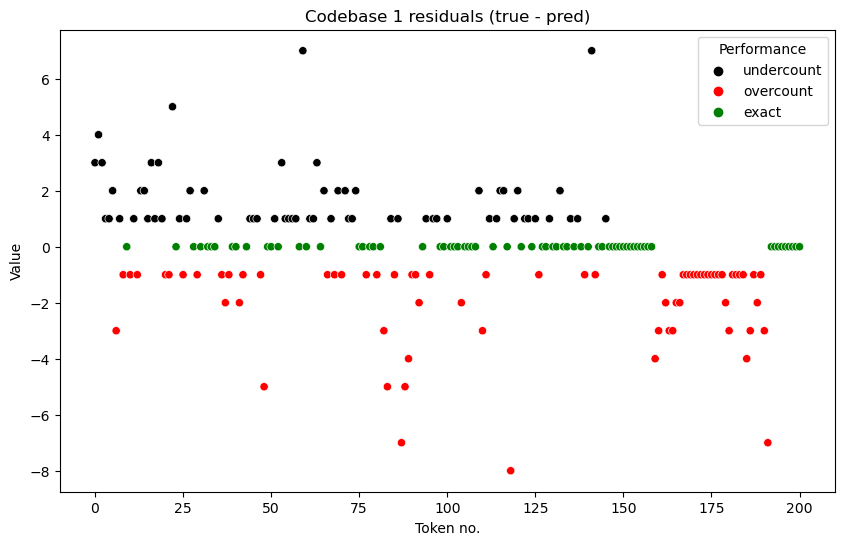

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

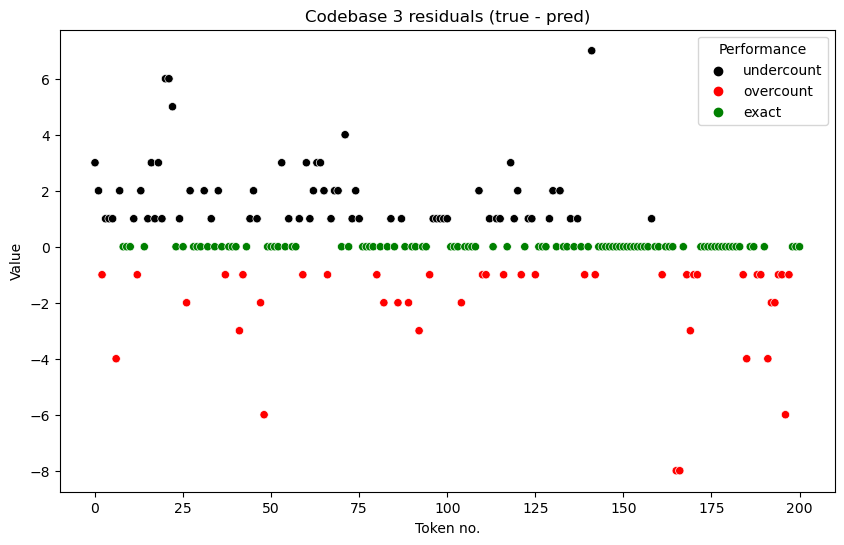

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

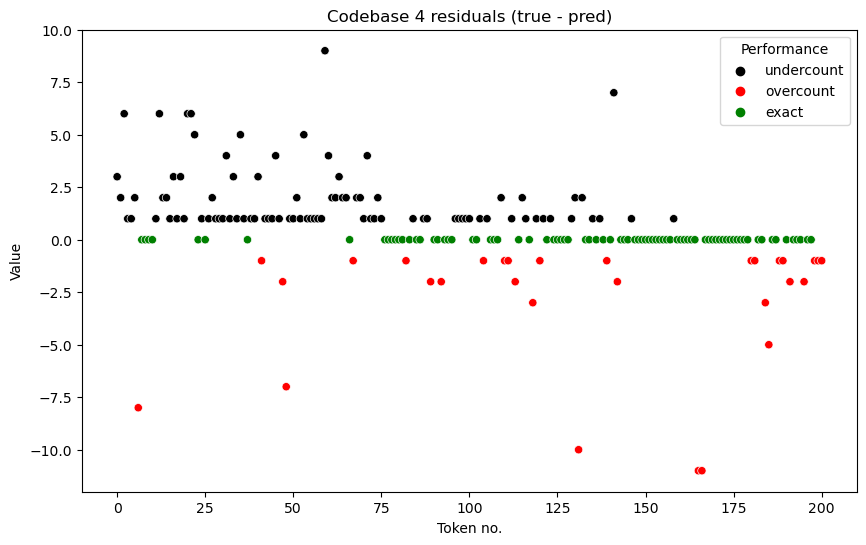

In [74]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.figure(figsize=(10, 6)) 
sns.scatterplot(data=merge_step3, x=merge_step3.index, y='count_cb1_residuals', hue = 'status_cb1', palette={'undercount': 'black', 'overcount': 'red', 'exact': 'green'})
plt.xlabel('Token no.')
plt.ylabel('Value')
plt.title('Codebase 1 residuals (true - pred)')
plt.legend(title='Performance')
plt.show()

plt.figure(figsize=(10, 6)) 
sns.scatterplot(data=merge_step3, x=merge_step3.index, y='count_cb3_residuals', hue = 'status_cb3', palette={'undercount': 'black', 'overcount': 'red', 'exact': 'green'})
plt.xlabel('Token no.')
plt.ylabel('Value')
plt.title('Codebase 3 residuals (true - pred)')
plt.legend(title='Performance')
plt.show()

plt.figure(figsize=(10, 6)) 
sns.scatterplot(data=merge_step3, x=merge_step3.index, y='count_cb4_residuals', hue = 'status_cb4', palette={'undercount': 'black', 'overcount': 'red', 'exact': 'green'})
plt.xlabel('Token no.')
plt.ylabel('Value')
plt.title('Codebase 4 residuals (true - pred)')
plt.legend(title='Performance')
plt.show()

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

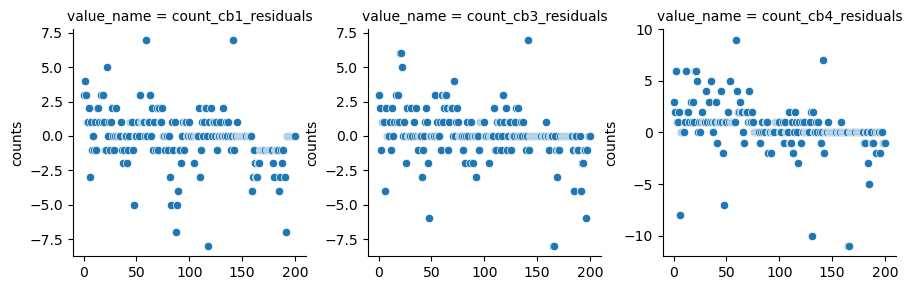

In [81]:
df_long = pd.melt(merge_step3, value_vars=['count_cb1_residuals', 'count_cb3_residuals', 'count_cb4_residuals'],
                  var_name='value_name', value_name='counts')

g = sns.FacetGrid(df_long, col='value_name', col_wrap=3, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x = merge_step3.index,y='counts')

# Add titles and adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("X-axis", "Y-axis")
plt.show()

Implementing word count residual analysis on new directory structure

In [5]:
import re
import pandas as pd
def parse_script(content):
    lines = content.strip().split('\n')
    data = []
    for line in lines:
        match = re.match(r"(.+?): (.+)", line)
        if match:
            speaker = match.group(1).strip()
            dialogue = match.group(2).strip()
            data.append([speaker, dialogue])
    return data

In [ ]:


with open("/om/user/arjunp/34_KS_Recording4-LR_2165-2465_CT-IC.txt", "r") as file:
    script_content = file.read()

# Parse and create the DataFrame as before
parsed_data = parse_script(script_content)
gold_standard_df = pd.DataFrame(parsed_data, columns=["speaker", "text"])
gold_standard_counts = return_counts(gold_standard_df['text'])
gold_df = pd.DataFrame(list(gold_standard_counts.items()) , columns=["token", "count"])
gold_df.to_csv('gold_standard_counts.csv', index=False)

In [4]:
def scrapeCBoutput(codebase_id, audiofilepath):
    cb_alltext = []
    main_output_dir  = '/om/user/arjunp/pipelineOutput'
    audio_name = os.path.basename(audiofilepath)[:-4]
    if codebase_id == 1:
        codebasename =  'yinruiqing'
    elif codebase_id == 2:
       codebasename =  'speechbox' 
         
    elif codebase_id == 3:
        codebasename =  'ashraf'
    else:
        codebasename =  'whisperx'

    csv_dir = os.path.join(main_output_dir, audio_name,codebasename)
    
    csv_files_list = glob.glob(csv_dir+'/*.csv')

    for csv in csv_files_list:
        df = pd.read_csv(csv)
        cb_alltext.append(df['text'].to_list())
    
    return cb_alltext

In [14]:
all_scraped = scrapeCBoutput(1,'34_KS_Recording4-LR_2165-2465_CT.wav') + scrapeCBoutput(2,'34_KS_Recording4-LR_2165-2465_CT.wav')+ scrapeCBoutput(3,'34_KS_Recording4-LR_2165-2465_CT.wav') +scrapeCBoutput(4,'34_KS_Recording4-LR_2165-2465_CT.wav') 

In [18]:
cb1_counts = return_counts(all_scraped[0])
cb2_counts = return_counts(all_scraped[1])
cb3_counts = return_counts(all_scraped[2])
cb4_counts = return_counts(all_scraped[3])

cb1_df = pd.DataFrame(list(cb1_counts.items()) , columns=["token", "count"])
cb2_df = pd.DataFrame(list(cb2_counts.items()) , columns=["token", "count"])
cb3_df = pd.DataFrame(list(cb3_counts.items()) , columns=["token", "count"])
cb4_df = pd.DataFrame(list(cb4_counts.items()) , columns=["token", "count"])

merge_step1 = pd.merge(gold_df, cb1_df, on='token', how='outer',suffixes=('_gold', '_cb1'))
merge_step2 = pd.merge(merge_step1, cb2_df, on='token', how='outer',suffixes=(None, '_cb2'))
merge_step3 = pd.merge(merge_step2, cb3_df, on='token', how='outer',suffixes=(None, '_cb3'))
merge_step4 = pd.merge(merge_step3, cb4_df, on='token', how='outer',suffixes=(None, '_cb4'))
merge_step4.columns = ['token', 'count_gold', 'count_cb1', 'count_cb2','count_cb3', 'count_cb4']
merge_step4.fillna(0, inplace=True)

In [20]:
merge_step4['count_cb1_residuals'] = merge_step4['count_gold'] - merge_step4['count_cb1']
merge_step4['count_cb2_residuals'] = merge_step4['count_gold'] - merge_step4['count_cb2']
merge_step4['count_cb3_residuals'] = merge_step4['count_gold'] - merge_step4['count_cb3']
merge_step4['count_cb4_residuals'] = merge_step4['count_gold'] - merge_step4['count_cb4']
merge_step4['status_cb1'] = merge_step4['count_cb1_residuals'].apply(lambda x: 'undercount' if x > 0 else ('overcount' if x < 0 else 'exact'))
merge_step4['status_cb2'] = merge_step4['count_cb2_residuals'].apply(lambda x: 'undercount' if x > 0 else ('overcount' if x < 0 else 'exact'))
merge_step4['status_cb3'] = merge_step4['count_cb3_residuals'].apply(lambda x: 'undercount' if x > 0 else ('overcount' if x < 0 else 'exact'))
merge_step4['status_cb4'] = merge_step4['count_cb4_residuals'].apply(lambda x: 'undercount' if x > 0 else ('overcount' if x < 0 else 'exact'))


In [21]:
merge_step4 

,token,count_gold,count_cb1,count_cb2,count_cb3,count_cb4,count_cb1_residuals,count_cb2_residuals,count_cb3_residuals,count_cb4_residuals,status_cb1,status_cb2,status_cb3,status_cb4
0,bah,3.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,undercount,undercount,undercount,undercount
1,ow,4.0,0.0,0.0,2.0,2.0,4.0,4.0,2.0,2.0,undercount,undercount,undercount,undercount
2,i,17.0,17.0,17.0,13.0,15.0,0.0,0.0,4.0,2.0,exact,exact,undercount,undercount
3,am,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,undercount,undercount,undercount,undercount
4,bad,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,undercount,undercount,undercount,undercount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,camera,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,exact,exact,overcount,exact
209,still,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,exact,exact,exact,overcount
210,sure,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,exact,exact,exact,overcount
211,ahh,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,exact,exact,exact,overcount


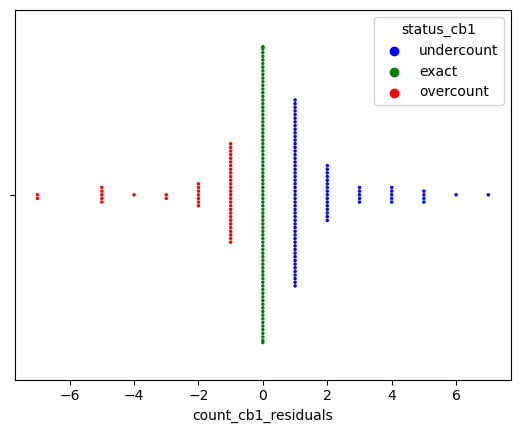

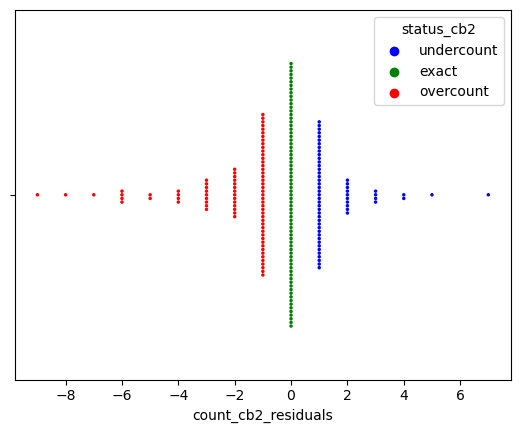

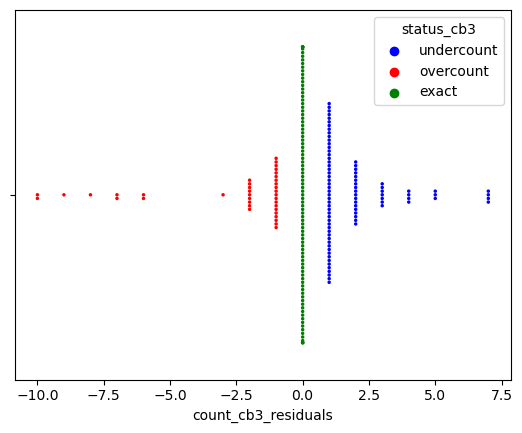

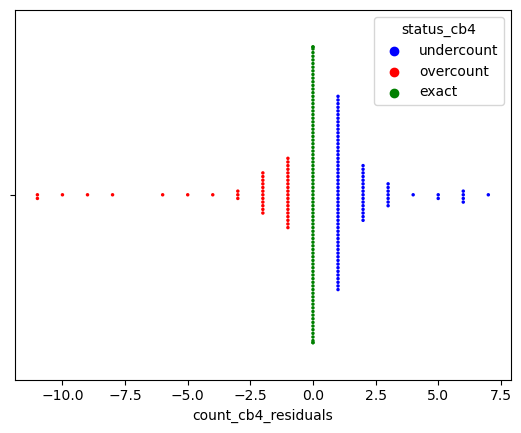

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.swarmplot(data=merge_step4, size=2.5, x="count_cb1_residuals", hue = "status_cb1",  palette={'undercount': 'blue', 'overcount': 'red', 'exact': 'green'} )
plt.show()
sns.swarmplot(data=merge_step4,size=2.5, x="count_cb2_residuals", hue = "status_cb2",  palette={'undercount': 'blue', 'overcount': 'red', 'exact': 'green'} )
plt.show()
sns.swarmplot(data=merge_step4,size=2.5, x="count_cb3_residuals", hue = "status_cb3",  palette={'undercount': 'blue', 'overcount': 'red', 'exact': 'green'} )
plt.show()
sns.swarmplot(data=merge_step4, size=2.5,x="count_cb4_residuals", hue = "status_cb4",  palette={'undercount': 'blue', 'overcount': 'red', 'exact': 'green'} )
plt.show()

Automation code for generating word-count analysis insights

In [42]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import glob

# Helper functions used: return_counts, parse_script, scrapeCBoutput

def createFullDataframe(name_of_audio, gold_transcript_path,source):
    gold_standard_df = createGoldTranscriptDataFrame (gold_transcript_path,source)
    gold_standard_counts = return_counts(gold_standard_df['text'])
    gold_df = pd.DataFrame(list(gold_standard_counts.items()) , columns=["token", "count"])
    
    all_scraped = scrapeCBoutput(1,name_of_audio) + scrapeCBoutput(2,name_of_audio)+ scrapeCBoutput(3,name_of_audio) +scrapeCBoutput(4,name_of_audio) 
    
    cb1_counts = return_counts(all_scraped[0])
    cb2_counts = return_counts(all_scraped[1])
    cb3_counts = return_counts(all_scraped[2])
    cb4_counts = return_counts(all_scraped[3])

    cb1_df = pd.DataFrame(list(cb1_counts.items()) , columns=["token", "count"])
    cb2_df = pd.DataFrame(list(cb2_counts.items()) , columns=["token", "count"])
    cb3_df = pd.DataFrame(list(cb3_counts.items()) , columns=["token", "count"])
    cb4_df = pd.DataFrame(list(cb4_counts.items()) , columns=["token", "count"])

    merge_step1 = pd.merge(gold_df, cb1_df, on='token', how='outer',suffixes=('_gold', '_cb1'))
    merge_step2 = pd.merge(merge_step1, cb2_df, on='token', how='outer',suffixes=(None, '_cb2'))
    merge_step3 = pd.merge(merge_step2, cb3_df, on='token', how='outer',suffixes=(None, '_cb3'))
    merge_step4 = pd.merge(merge_step3, cb4_df, on='token', how='outer',suffixes=(None, '_cb4'))
    merge_step4.columns = ['token', 'count_gold', 'count_cb1', 'count_cb2','count_cb3', 'count_cb4']
    merge_step4.fillna(0, inplace=True)

    for i in range(1,5):
        merge_step4[f'count_cb{i}_residuals'] = merge_step4['count_gold'] - merge_step4[f'count_cb{i}']
        merge_step4[f'status_cb{i}'] = merge_step4[f'count_cb{i}_residuals'].apply(lambda x: 'undercount' if x > 0 else ('overcount' if x < 0 else 'exact'))
    merge_step4['audio'] = name_of_audio
    return merge_step4


def createGoldTranscriptDataFrame(link, type):
    if type == 'CHILDES':
        og_df = pd.read_csv(link)
        filtered_df = og_df[[  'speaker_code', 'speaker_role','gloss', 'media_start','media_end']]
        filtered_df.columns = ['speaker_code', 'speaker_role','text', 'media_start','media_end']
    
    else:
        with open(link, "r") as file:
            script_content = file.read()

        parsed_data = parse_script(script_content)
        filtered_df = pd.DataFrame(parsed_data, columns=["speaker", "text"])

    return filtered_df



def createSwarmPlots(list_of_audio, list_of_gold_transcripts, sources):
    length = len(list_of_audio)
    list_of_dfs = []

    for i in range (length):
        list_of_dfs.append(createFullDataframe(list_of_audio[i], list_of_gold_transcripts[i], sources[i]))
    
    df = pd.concat(list_of_dfs)
    
    melted = pd.melt(df, value_vars=['count_cb1_residuals', 'count_cb2_residuals', 'count_cb3_residuals', 'count_cb4_residuals'],
                  var_name='value_name', value_name='counts', id_vars=['audio','status_cb1', 'status_cb2', 'status_cb3', 'status_cb4'])
    
    status= []
    for i in melted['counts']:
        if i>0:
            status.append('undercount')
        elif i<0:
            status.append('overcount')
        else:
            status.append('exact')

    melted['token_fate'] = status

    g = sns.FacetGrid(melted, col="value_name", row="audio",hue="token_fate", margin_titles=True, height=6, aspect=1)
 
    g.map(sns.swarmplot,  "counts",size=2)
 
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
 
    plt.subplots_adjust(top=0.9)
    legend = g.add_legend()
     
    g.set_axis_labels("Residual", " ",fontsize=20)


    for ax in g.axes.flat:
        legend = ax.get_legend()
        if legend is not None:
            for text in legend.get_texts():
                text.set_fontsize(18)  

    g.fig.suptitle('Token count residuals per codebase, per audiofile',fontsize=24)
    plt.show()

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

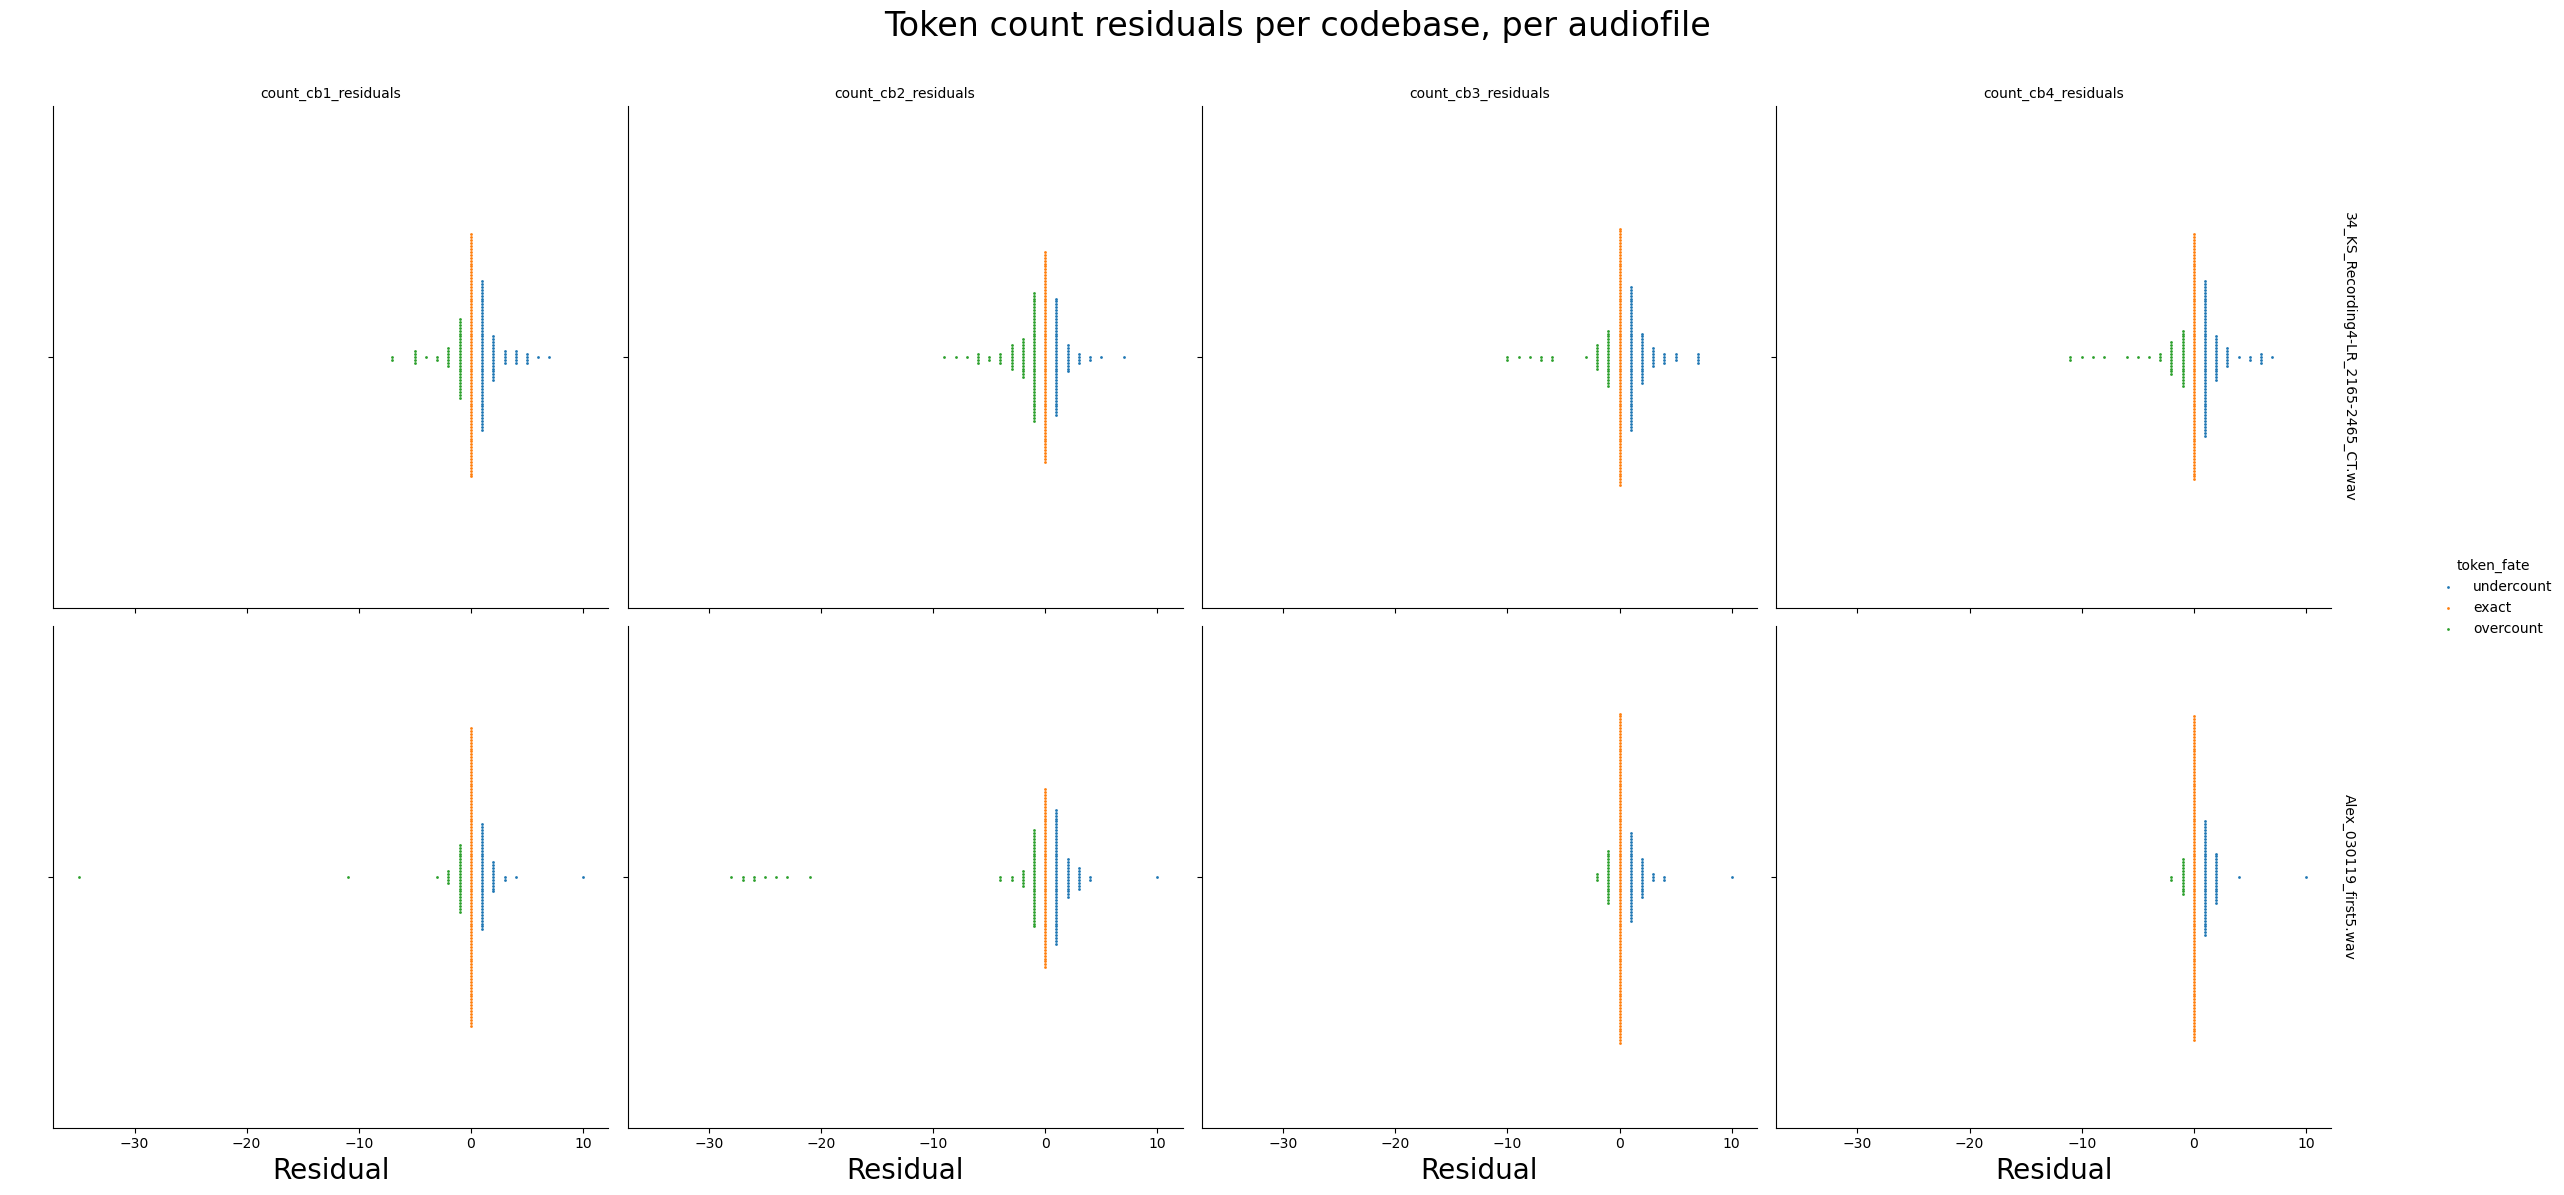

In [43]:
list_of_audio = ['34_KS_Recording4-LR_2165-2465_CT.wav',   'Alex_030119_first5.wav' ]
list_of_gold_transcripts = ['/om/user/arjunp/goldTranscripts/34_KS_Recording4-LR_2165-2465_CT.txt', '/om/user/arjunp/goldTranscripts/Alex_030119_first5_gold.csv']
sources = ['BOX', 'CHILDES' ]
createSwarmPlots(list_of_audio, list_of_gold_transcripts, sources)